<a href="https://colab.research.google.com/github/AtaAtas/MYZ_307/blob/main/MYZ_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)  # same distribution for each run

n_samples = 500  # 500 per class → total 1000
mean1 = [1.5, -0.5]     # class +1 mean (x, y)
mean2 = [-1.0,  0.8]    # class -1 mean (x, y)

# Negative correlation to examine a different scenario than the given example.
# Also different variances for increasing the scattering more and creating...
# ...an environment prone to push the classifier to make wrong classifications.
cov = [[1.2, -0.4],
       [-0.4, 0.8]]

# Generate class data (each is 500x2)
X1 = np.random.multivariate_normal(mean1, cov, n_samples)  # class +1
X2 = np.random.multivariate_normal(mean2, cov, n_samples)  # class -1

# Labels: +1 and -1
y1 = np.ones(n_samples)
y2 = -np.ones(n_samples)

# Combine
X = np.vstack((X1, X2)) #(1000 ,2)
y = np.hstack((y1, y2)) #(1000, )
print(X)

[[-0.14880265  0.86876631]
 [ 1.37434174  1.53627355]
 [-0.79313403  0.06306258]
 ...
 [-1.16423566  0.98694055]
 [-2.37229886  1.7866036 ]
 [-0.34388364 -0.75133233]]


In [142]:
# Combine features and labels into one DataFrame
df = pd.DataFrame({
    "x1": X[:, 0],     # first feature (horizontal axis)
    "x2": X[:, 1],     # second feature (vertical axis)
    "label": y         # class label (+1 or -1)
})

# Define save path (change if needed)
data_path = "/content/drive/MyDrive/Colab_Notebooks/MYZ_HW2/distribution.csv"

# Save to CSV
df.to_csv(data_path, index=False)
ata_s_data = pd.read_csv(data_path)
X = np.vstack((
    np.array(ata_s_data.iloc[:, 0]),
    np.array(ata_s_data.iloc[:, 1])
))
X = np.transpose(X)
y = np.array(ata_s_data.iloc[:, 2])
print(f"shape_X: {np.shape(X)}, shape_y: {np.shape(y)}")

shape_X: (1000, 2), shape_y: (1000,)


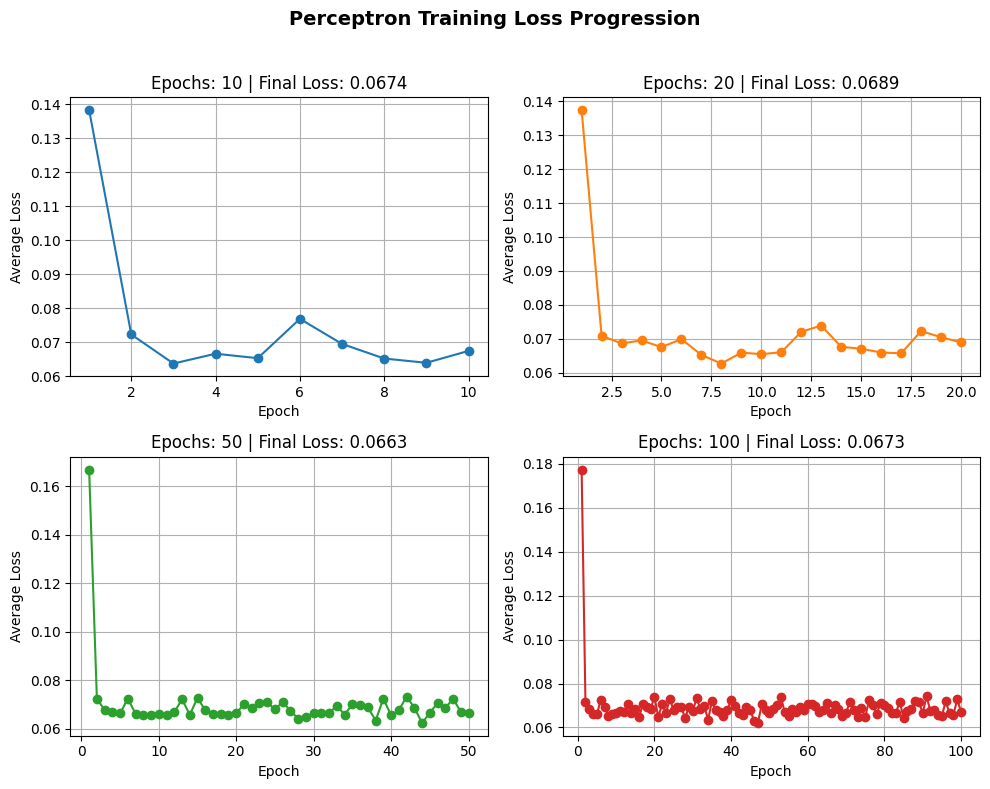

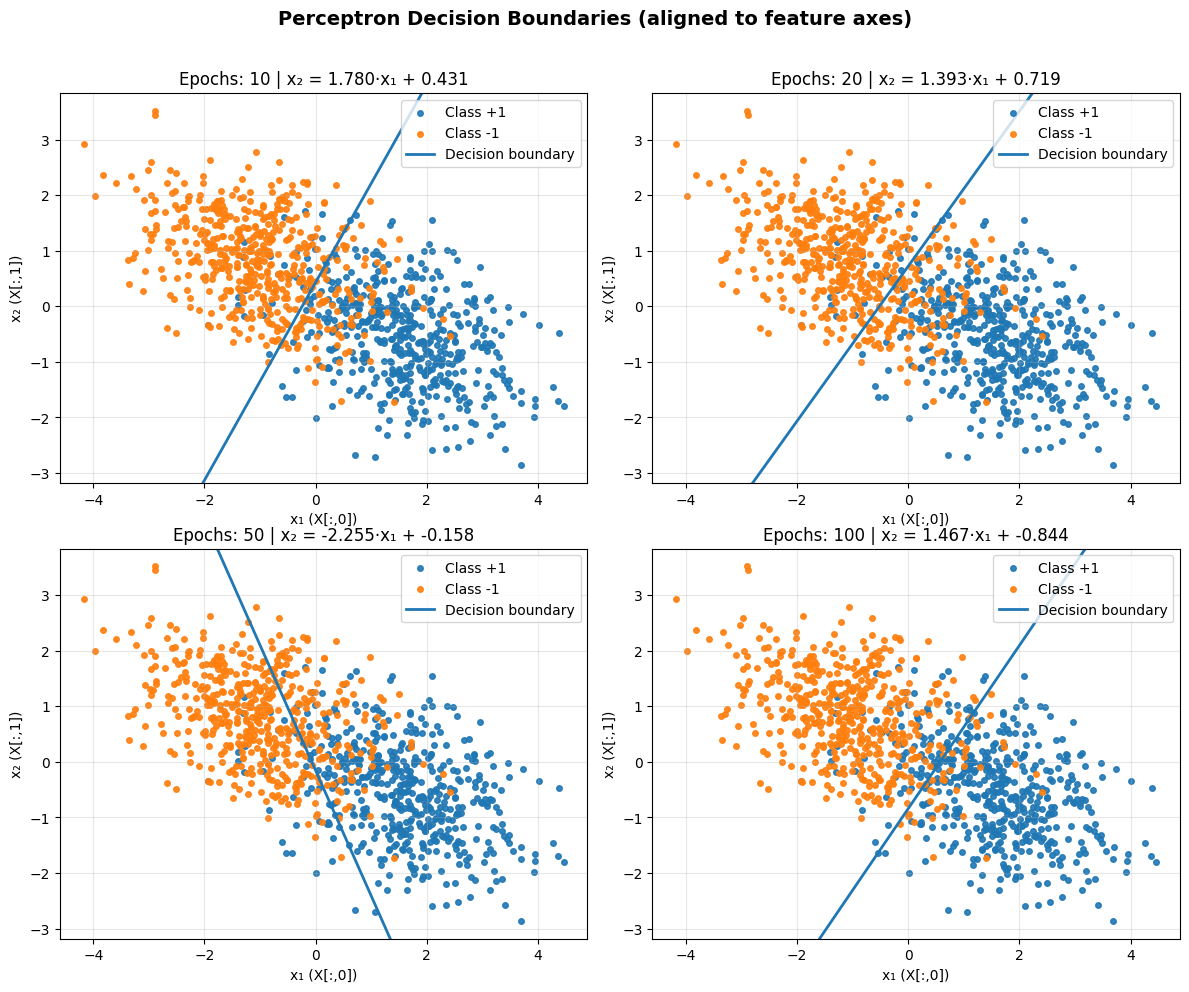

In [145]:

# The preceptron method given in exercise3-manual.ipynb in the homework files

# ****************************************************************************

#  Manuel numpy fonksiyonları ile model oluşturup eğitme

# Her epoch sonunda kayıp değerlerini izlemek için global listeler tanımlanıyor.
global losses_manuel
losses_manuel=[]

# Perceptron eğitim algoritması (manuel uygulama)
# Simple, drop-in fine-tuned perceptron (same interface)
def perceptron_train(X, y, lr=0.05, epochs=20, seed=42):
    """
    X: (n,d), y in {-1,+1}
    lr: learning rate
    epochs: number of passes over the data
    Returns: w, b, final_epoch_metric
    """
    rng = np.random.default_rng(seed)   # reproducible shuffling
    n, d = X.shape
    w = np.random.rand(d)               # (d,)
    b = np.random.rand()                # scalar

    # I HAD TO SHUFFLE THE DATA BECAUSE THE CLASSIFIER WOULDN'T WORK OTHERWISE..
    # ..I ASSUME IT GOT STUCK ON SOME LOCAL EXTREMUM POINT
    for epoch in range(epochs):
        # shuffle sample order each epoch
        idx = rng.permutation(n)

        wrong = 0
        epoch_loss_sum = 0.0

        for i in idx:
            margin = y[i] * (np.dot(w, X[i]) + b)
            if margin <= 0:
                w += lr * y[i] * X[i]
                b += lr * y[i]
                wrong += 1
                epoch_loss_sum += -margin

        avg_loss = epoch_loss_sum / max(1, wrong) if wrong > 0 else 0.0
        losses_manuel.append(avg_loss)

    final_loss = losses_manuel[-1]
    return w, b, final_loss


# Eğitim işlemini başlat
w_0, b_0, fl_0 = perceptron_train(X, y, lr=0.05, epochs=10)
w_1, b_1, fl_1 = perceptron_train(X, y, lr=0.05, epochs=20)
w_2, b_2, fl_2 = perceptron_train(X, y, lr=0.05, epochs=50)
w_3, b_3, fl_3 = perceptron_train(X, y, lr=0.05, epochs=100)
# ****************************************************************************

# Number of epochs used in each perceptron training
epoch_counts = [10, 20, 50, 100]

# Split indices based on cumulative epoch counts
split_indices = np.cumsum(epoch_counts)

# Separate the global loss list accordingly
L0 = losses_manuel[0:split_indices[0]]
L1 = losses_manuel[split_indices[0]:split_indices[1]]
L2 = losses_manuel[split_indices[1]:split_indices[2]]
L3 = losses_manuel[split_indices[2]:split_indices[3]]

# Combine for looping
loss_sets = [L0, L1, L2, L3]

# --- Create Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()  # flatten 2x2 grid

for i, (ax, L) in enumerate(zip(axes, loss_sets)):
    ax.plot(range(1, len(L)+1), L, marker='o', color='C'+str(i))
    final_loss = L[-1] if len(L) > 0 else np.nan
    ax.set_title(f"Epochs: {epoch_counts[i]} | Final Loss: {final_loss:.4f}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Loss")
    ax.grid(True)

plt.suptitle("Perceptron Training Loss Progression", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust for suptitle
plt.show()

# --- learned params ---
weights = [w_0, w_1, w_2, w_3]
biases  = [b_0, b_1, b_2, b_3]
epochs  = [10, 20, 50, 100]

# ensure labels are {-1, +1}
if not np.array_equal(np.unique(y), np.array([-1, 1])):
    y = np.where(y > 0, 1, -1)

# axes limits from data
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
x_pad = 0.05 * (x_max - x_min + 1e-12)
y_pad = 0.05 * (y_max - y_min + 1e-12)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, w, b, ep in zip(axes, weights, biases, epochs):
    # scatter
    ax.scatter(X[y==1, 0],  X[y==1, 1], s=16, label='Class +1', alpha=0.9)
    ax.scatter(X[y==-1, 0], X[y==-1, 1], s=16, label='Class -1', alpha=0.9)

    # decision boundary: w1*x1 + w2*x2 + b = 0  -> x2 = -(w1/w2)x1 - b/w2
    if abs(w[1]) > 1e-12:
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        # draw infinite line in the SAME axis frame
        ax.axline((0.0, intercept), slope=slope, linewidth=2, label='Decision boundary')
        title_eq = f"x₂ = {slope:.3f}·x₁ + {intercept:.3f}"
    else:
        # vertical line: x1 = -b/w0
        x_line = -b / (w[0] + 1e-12)
        ax.axvline(x_line, linewidth=2, label='Decision boundary')
        title_eq = f"x₁ = {x_line:.3f} (vertical)"

    # styling
    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("x₁ (X[:,0])")
    ax.set_ylabel("x₂ (X[:,1])")
    ax.set_title(f"Epochs: {ep} | {title_eq}")
    ax.legend(loc='best')

plt.suptitle("Perceptron Decision Boundaries (aligned to feature axes)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



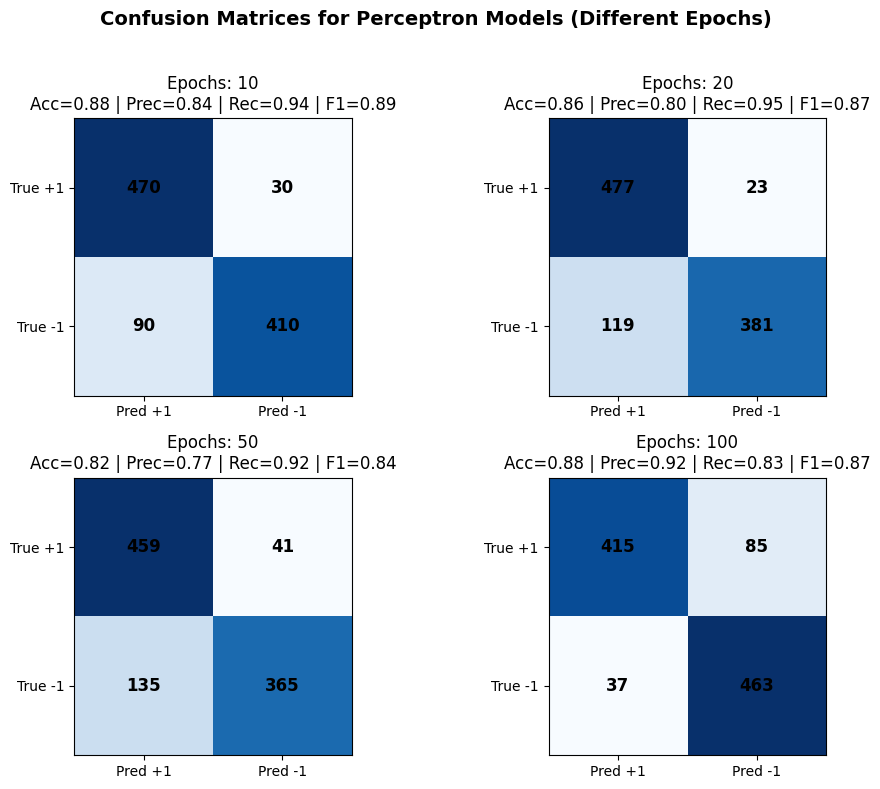

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# === Model parameters ===
weights = [w_0, w_1, w_2, w_3]
biases  = [b_0, b_1, b_2, b_3]
epochs  = [10, 20, 50, 100]

# === Function to calculate confusion matrix + metrics ===
def evaluate_perceptron(w, b, X, y):
    scores = X @ w + b
    y_pred = np.where(scores >= 0, 1, -1)

    tp = np.sum((y == 1)  & (y_pred == 1))
    tn = np.sum((y == -1) & (y_pred == -1))
    fp = np.sum((y == -1) & (y_pred == 1))
    fn = np.sum((y == 1)  & (y_pred == -1))

    cm = np.array([[tp, fn],
                   [fp, tn]])

    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1_score  = 2 * (precision * recall) / (precision + recall + 1e-12)

    return cm, accuracy, precision, recall, f1_score


# === Create subplots (2×2 for 4 models) ===
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, w, b, ep in zip(axes, weights, biases, epochs):
    cm, acc, prec, rec, f1 = evaluate_perceptron(w, b, X, y)

    # plot confusion matrix
    im = ax.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12, fontweight="bold")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred +1", "Pred -1"])
    ax.set_yticklabels(["True +1", "True -1"])
    ax.set_title(f"Epochs: {ep}\nAcc={acc:.2f} | Prec={prec:.2f} | Rec={rec:.2f} | F1={f1:.2f}")
    ax.grid(False)

# colorbar for all
plt.suptitle("Confusion Matrices for Perceptron Models (Different Epochs)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
